In [1]:
import torch
import torch.nn as nn
import scipy.io as sio
import torch.optim as optim
import numpy as np
import torch.nn.functional as F
import os
import pickle
import time
import matplotlib.pyplot as plt

In [2]:
class MyANN(nn.Module):
    def __init__(self, input_size, hidden_layer, hidden_size, output_size):
        """
        
        """
        super(MyANN, self).__init__()

        self.input_size = input_size
        self.hidden_layer = hidden_layer
        self. hidden_size = hidden_size
        self.output_size = output_size
        # 构体模型
        self.model = self.get_model_structure()

    def get_model_structure(self):
        """
        根据input_size, hidden_layer, hidden_size, output_size构建模型结构
        """
        layer_list = []
        # input到hidden
        layer_list.append(nn.Linear(self.input_size, self.hidden_size))
        layer_list.append(nn.ReLU())
        #layer_list.append(nn.Sigmoid())

        for i in range(self.hidden_layer - 1):
            layer_list.append(nn.Linear(self.hidden_size, self.hidden_size))
            #layer_list.append(nn.Sigmoid())
            layer_list.append(nn.ReLU())

        layer_list.append(nn.Linear(self.hidden_size, self.output_size))

        model = nn.Sequential(*layer_list)
        return model

    def forward(self, x):
        """

        """
        output = self.model(x)
        return output

In [4]:
# 加载数据--feature
dataset_feature = sio.loadmat(r'../data/interp_00_all.mat')
print(dataset_feature.keys())

dict_keys(['__header__', '__version__', '__globals__', 'velocity10_00', 'degree_00', 'u10_00', 'v10_00', 'rh2_00', 't2_00', 'slp_00'])


In [5]:
# 加载数据--label
with open('../data/real_dataset_noabnormal', 'rb') as f:
    real_target = pickle.load(f)
print(real_target.keys())

Index(['站位编号', '获取时间', '经度', '纬度', '平均风速', '平均风向', '平均风速_10m'], dtype='object')


In [6]:
# 观测数据分组（分站位）
df_group = real_target.groupby('站位编号')
real_velocity_00 = df_group.get_group(0)['平均风速_10m'].values
real_time_00 = df_group.get_group(0)['获取时间'].values

In [7]:
label_velocity_00 = real_velocity_00.reshape((-1,1))

In [8]:
label_velocity_00.shape

(14337, 1)

In [9]:
# 提取数据
velocity10 = dataset_feature['velocity10_00']
slp = dataset_feature['slp_00']
t2 = dataset_feature['t2_00']

In [10]:
feature = np.concatenate((velocity10, slp, t2), axis=0).T

In [11]:
# 归一化参数
feature_min = np.min(feature, axis=0)
feature_max = np.max(feature, axis=0)
# 归一化
feature = (feature - feature_min) / (feature_max - feature_min)

In [12]:
sample_num, feature_num = feature.shape

In [13]:
# 训练数据转为tensor对象
feature_target = torch.from_numpy(feature).to(torch.float32)
label_target = torch.from_numpy(label_velocity_00).to(torch.float32)

In [14]:
# 划分数据集
feature_train = feature_target[:round(0.7*sample_num),:]
label_train = label_target[:round(0.7*sample_num),:]
time_train = real_time_00[:round(0.7*sample_num)]

feature_val = feature_target[round(0.7*sample_num):round(0.8*sample_num),:]
label_val = label_target[round(0.7*sample_num):round(0.8*sample_num),:]
time_val = real_time_00[round(0.7*sample_num):round(0.8*sample_num)]

feature_test = feature_target[round(0.8*sample_num):,:]
label_test = label_target[round(0.8*sample_num):,:]
time_test = real_time_00[round(0.8*sample_num):]

In [14]:
# 保存 训练 和 测试 数据集
parameter_dict_norm = {'feature_min': feature_min, 'feature_max': feature_max}
data_dict_train = {'feature_train': feature_train.numpy(),
                   'label_train': label_train.numpy(),
                   'time_train': time_train}
data_dict_test = {'feature_test': feature_test.numpy(),
                   'label_test': label_test.numpy(),
                   'time_test': time_test}

sio.savemat('../data/parameter_norm_00.mat', parameter_dict_norm)
sio.savemat('../data/dataset_train_00.mat', data_dict_train)
sio.savemat('../data/dataset_test_00.mat', data_dict_test)

In [15]:
print(feature_train.shape, label_train.shape, feature_val.shape, label_val.shape, feature_test.shape, label_test.shape)

torch.Size([10036, 3]) torch.Size([10036, 1]) torch.Size([1434, 3]) torch.Size([1434, 1]) torch.Size([2867, 3]) torch.Size([2867, 1])


In [15]:
# 计算训练前测试集数据的相关系数
correlation = np.corrcoef(feature_test[:,0], label_test.flatten())[0, 1]
print("皮尔逊相关系数:", correlation)

皮尔逊相关系数: 0.8002306635714694


In [20]:
# 计算训练前测试集数据的均方根误差
errors = feature_test.numpy()[:,0] - label_test.numpy().flatten()
squared_errors = errors ** 2
mse = squared_errors.mean()
rmse = np.sqrt(mse)

print("均方根误差（RMSE）: ", rmse)

均方根误差（RMSE）:  9.142858


In [16]:
# 编写训练逻辑

def training_loop(n_epochs, optimizer, model, loss_fn, feature_train, label_train, feature_val, label_val):
    """

    """
    # 选择模型
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(device)
    # 移动到device上运算
    model.to(device)
    feature_train = feature_train.to(device)
    label_train = label_train.to(device)
    feature_val = feature_val.to(device)
    label_val = label_val.to(device)

    # 初始化上一轮的loss_train
    loss_train_previous = 0
    for epoch in range(1, n_epochs + 1):

        predict_train = model(feature_train)
        loss_train = loss_fn(predict_train, label_train)

        optimizer.zero_grad()
        loss_train.backward()

        optimizer.step()

        with torch.no_grad():
                predict_val= model(feature_val)
                loss_val = loss_fn(predict_val, label_val)

        if epoch % 200 == 0:
            print('Epoch: %d, \t Loss_train: %f, \t Loss_val: %f' % (epoch, float(loss_train), float(loss_val)))

        # loss_train不再变化时跳出循环
#         print(loss_train, loss_train_previous)
        if loss_train - loss_train_previous == 0:
            break

        # 更新loss_train_previous
        loss_train_previous = loss_train

In [17]:
# 定义训练参数
repeat = 3
hidden_layer_arr = range(1, 3 + 1, 1)
hidden_size_arr = range(3, 60 + 3, 3)
# repeat = 1
# hidden_layer_arr = [4]
# hidden_size_arr = [3]

In [20]:
# 保存训练参数--遍历结构所用参数
find_struction_parameter_dict = {'repeat': repeat, 'hidden_layer_arr': hidden_layer_arr,
                                'hidden_size_arr': hidden_size_arr}
sio.savemat('../data/find_struction_parameter_00.mat', find_struction_parameter_dict)

In [18]:
# 创建度量存储数组
rmse_arr = np.empty((repeat, len(hidden_layer_arr), len(hidden_size_arr)))
corrcoef_arr = np.empty((repeat, len(hidden_layer_arr), len(hidden_size_arr)))

In [19]:
model_dir = r'../model_00/'

In [ ]:
# 开始时间戳
start_time = time.time()
# 循环训练
for i, loop in enumerate(range(repeat)):
    for j, hidden_layer in enumerate(hidden_layer_arr):
        for k, hidden_size in enumerate(hidden_size_arr):
            # 定义模型
            model = MyANN(3, hidden_layer, hidden_size, 1)
            # 训练次数
            n_epochs = 3000
            # 优化器
            optimizer = optim.Adam(model.parameters(), lr=1e-2)
            # 损失函数
            loss_fn = nn.MSELoss()
            # 训练模型
            training_loop(n_epochs, optimizer, model, loss_fn, feature_train, label_train,
                          feature_val, label_val)
            # model设置为评估模式
            model.eval()
            # 取消自动求导
            for param in model.parameters():
                param.requires_grad = False
            # 手动清除 GPU 缓存
            torch.cuda.empty_cache()
            # 转回cpu
            model.to(torch.device("cpu"))
            # 计算预测值
            predictions = model(feature_test)
            # 转为numpy数组
            label_test_np = np.squeeze(label_test.numpy())
            predictions_np = np.squeeze(predictions.numpy())
            # 计算度量
            rmse = np.sqrt(np.mean((predictions_np - label_test_np)**2))
            corrcoef = np.corrcoef(predictions_np, label_test_np)[0, 1]
            print(rmse, corrcoef)
            # 更新容器
            rmse_arr[i, j, k] = rmse
            corrcoef_arr[i, j, k] = corrcoef

            # 保存模型
            filename = 'station00'+'loop'+'{:02d}'.format(loop)+'hiddenlayer'+'{:02d}'.format(hidden_layer)\
            +'hiddensize'+'{:02d}'.format(hidden_size)+'.pth'
            model_path = os.path.join(model_dir, filename)
            print(model_path)
            torch.save(model.state_dict(), model_path)

# 训练结束时间戳
end_time = time.time()
# 计算并打印训练时长
training_time = end_time - start_time
print(f"Training took {training_time:.2f} seconds.")

In [ ]:
print(start_time, end_time)

In [ ]:
print(np.nanmin(rmse_arr) , np.nanmax(corrcoef_arr))

In [ ]:
# 保存度量
sio.savemat('../data/measure_velocity_00.mat',
            {'rmse_arr': rmse_arr, 'corrcoef_arr': corrcoef_arr})

## 寻找最优模型

In [97]:
# # 将numpy数组中的nan值替换为负无穷大
# corrcoef = np.nan_to_num(corrcoef_arr, nan=-np.inf)
# print(np.unravel_index(np.argmax(corrcoef), corrcoef.shape))
# print(np.unravel_index(np.argmin(rmse_arr), rmse_arr.shape))
# print(corrcoef[0,1,1] , rmse_arr[2,2,11])
# print(hidden_layer_arr[1] , hidden_size_arr[1])
# print(hidden_layer_arr[2] , hidden_size_arr[11])

In [21]:
# 加载所需参数
measure_dataset = sio.loadmat('../data/measure_velocity_00.mat')
rmse_arr = measure_dataset['rmse_arr']
corr_arr = measure_dataset['corrcoef_arr']

In [21]:
# 将numpy数组中的nan值替换为负无穷大
corr_arr = np.nan_to_num(corr_arr, nan=-np.inf)

In [22]:
# 寻找最优结构函数
def find_best_model(measure_arr, measure_str, repeat, hidden_layer_arr, hidden_size_arr):
    # 判断基于哪种度量确定最优模型
    if measure_str == 'rmse':
        measure_best = np.nanmin(measure_arr)
    elif measure_str == 'corr':
        measure_best = np.nanmax(measure_arr)
    # 构建最优模型的坐标索引
    r_idx, hl_idx, hs_idx = np.where(measure_arr == measure_best)
    print('最优坐标索引:', int(r_idx), int(hl_idx), int(hs_idx))
    print('最优性能: ', measure_arr[r_idx, hl_idx, hs_idx])
    # 最优结构
    r_best = list(range(repeat))[int(r_idx)]
    hl_best = hidden_layer_arr[int(hl_idx)]
    hs_best = hidden_size_arr[int(hs_idx)]

    return r_best, hl_best, hs_best

def create_best_filepath(data_dir, station, r_best, hl_best, hs_best):
    filename = 'station'+'{:02d}'.format(station)+'loop'+'{:02d}'.format(r_best)+'hiddenlayer'+\
    '{:02d}'.format(hl_best)+'hiddensize'+'{:02d}'.format(hs_best)+'.pth'
    model_path = os.path.join(model_dir, filename)
    return model_path

In [23]:
## 基于最优相关系数寻找模型
r_best, hl_best, hs_best = find_best_model(rmse_arr, 'rmse', repeat, hidden_layer_arr, hidden_size_arr)
print('最优结构: ', r_best, hl_best, hs_best)

最优坐标索引: 2 2 11
最优性能:  [2.36430955]
最优结构:  2 3 36


C:\Users\lqh13\AppData\Local\Temp\ipykernel_24508\3352638507.py:10: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('最优坐标索引:', int(r_idx), int(hl_idx), int(hs_idx))
C:\Users\lqh13\AppData\Local\Temp\ipykernel_24508\3352638507.py:13: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  r_best = list(range(repeat))[int(r_idx)]
C:\Users\lqh13\AppData\Local\Temp\ipykernel_24508\3352638507.py:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  hl_best = hidden_layer_arr[int(

In [24]:
corr_arr[2,2,11] , rmse_arr[2,2,11]

(0.8028686601292059, 2.364309549331665)

In [25]:
best_model_path = create_best_filepath(model_dir, 0, r_best, hl_best, hs_best)
print(best_model_path)

../model_00/station00loop02hiddenlayer03hiddensize36.pth


In [26]:
# 加载的模型参数
state_dict = torch.load(best_model_path)
# 加载模型
input_size = 3
output_size = 1
model = MyANN(input_size,hl_best,hs_best,output_size)
# 然后加载保存的参数
model.load_state_dict(state_dict)
# 模型设置为评估模式
model.eval()

MyANN(
  (model): Sequential(
    (0): Linear(in_features=3, out_features=36, bias=True)
    (1): ReLU()
    (2): Linear(in_features=36, out_features=36, bias=True)
    (3): ReLU()
    (4): Linear(in_features=36, out_features=36, bias=True)
    (5): ReLU()
    (6): Linear(in_features=36, out_features=1, bias=True)
  )
)

In [27]:
# 查看模型参数
for param in model.parameters():
    print(param)

Parameter containing:
tensor([[ 0.8066, -0.3637, -0.5184],
        [ 0.7398, -0.1138, -0.2436],
        [-0.6013, -0.5138, -0.3515],
        [-0.2978, -0.4396, -0.1332],
        [ 0.9599, -0.5018, -0.1855],
        [-0.3745,  0.2545,  0.0625],
        [ 0.4278, -0.1152, -0.2842],
        [ 0.3747, -0.2732, -0.2789],
        [-0.2312, -0.4165, -0.4087],
        [ 1.0882, -0.3519, -0.0345],
        [ 0.8383,  0.0854, -0.3272],
        [-0.1477,  0.6203,  0.2244],
        [-0.5364, -0.2892,  0.0626],
        [ 0.0822, -0.2433,  0.2320],
        [-0.1534,  0.0289, -0.1204],
        [ 0.4464,  0.2465, -0.0924],
        [ 0.8634, -0.4184, -0.0892],
        [-0.1872, -0.2138, -0.4291],
        [ 0.4073, -0.1227,  0.2826],
        [ 0.6540,  0.3862, -0.4252],
        [-0.2934,  0.1350,  0.3664],
        [ 0.3396, -0.4255, -0.5137],
        [-0.0748, -0.5274, -0.4545],
        [-0.5147, -0.2247, -0.2927],
        [-0.3553,  0.1810, -0.6041],
        [ 0.0592,  0.3474, -0.0541],
        [ 0.1141

In [28]:
# 加载 归一化参数 训练集 和 测试集
parameter_norm = sio.loadmat('../data/parameter_norm_00.mat')
feature_min = parameter_norm['feature_min'].flatten()
feature_max = parameter_norm['feature_max'].flatten()

dataset_train = sio.loadmat('../data/dataset_train_00.mat')
feature_train = dataset_train['feature_train']
label_train = dataset_train['label_train']
time_train = dataset_train['time_train'].flatten()

dataset_test = sio.loadmat('../data/dataset_test_00.mat')
feature_test = dataset_test['feature_test']
label_test = dataset_test['label_test']
time_test = dataset_test['time_test'].flatten()

In [29]:
# 特征由ndarray对象 转为 tensor对象
feature_train_tensor = torch.from_numpy(feature_train)
feature_test_tensor = torch.from_numpy(feature_test)

### 训练集结果

In [30]:
## 加载训练集上的数据
velocity_train_feature = feature_train[:, 0].flatten() * (feature_max[0] - feature_min[0]) + feature_min[0]
velocity_train_prediction = model(feature_train_tensor).detach().numpy().flatten()
velocity_train_label = label_train.flatten()

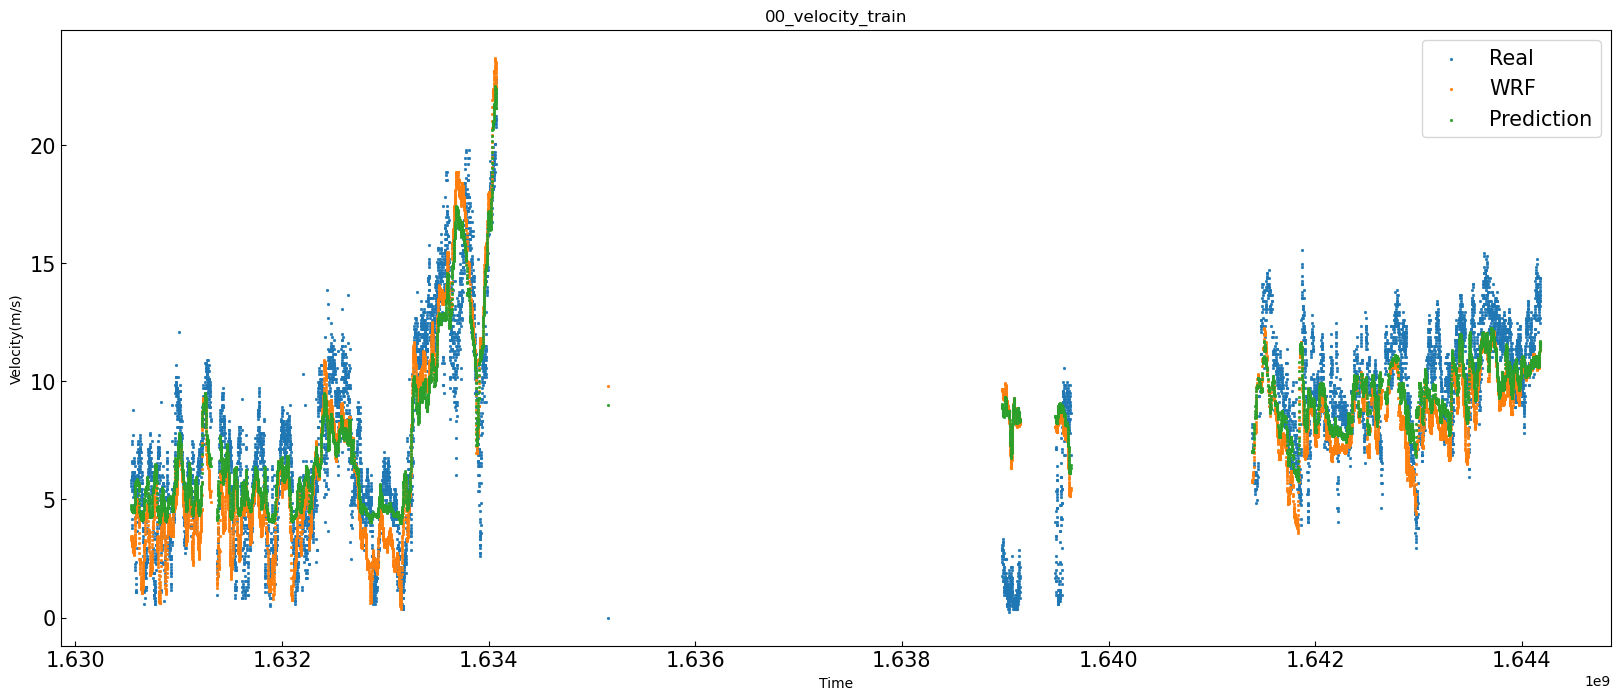

In [31]:
size = 3
line_width = 0.5
# 设置画布大小
figsize = (20, 8)
# 创建画布
plt.figure(figsize = figsize)
## 全局设置
# 绘制第一幅图
plt.scatter(time_train, velocity_train_label, s=size, linewidth=line_width, label='Real')
plt.scatter(time_train, velocity_train_feature, s=size, linewidth=line_width, label='WRF')
plt.scatter(time_train, velocity_train_prediction, s=size, linewidth=line_width, label='Prediction')
plt.tick_params(direction='in', labelsize=15)
plt.ylabel('Velocity(m/s)')
plt.xlabel('Time')
plt.legend(loc='upper right',fontsize=15)
plt.title('00_velocity_train')
plt.show()

### 测试集结果

In [32]:
## 训练集上结果
velocity_test_feature = feature_test[:, 0].flatten() * (feature_max[0] - feature_min[0]) + feature_min[0]
velocity_test_prediction = model(feature_test_tensor).detach().numpy().flatten()
velocity_test_label = label_test.flatten()

In [33]:
import pandas as pd
# 将时间转为正常形式
timestamps = time_test * 10**9
datetime = pd.to_datetime(timestamps, unit='ns')

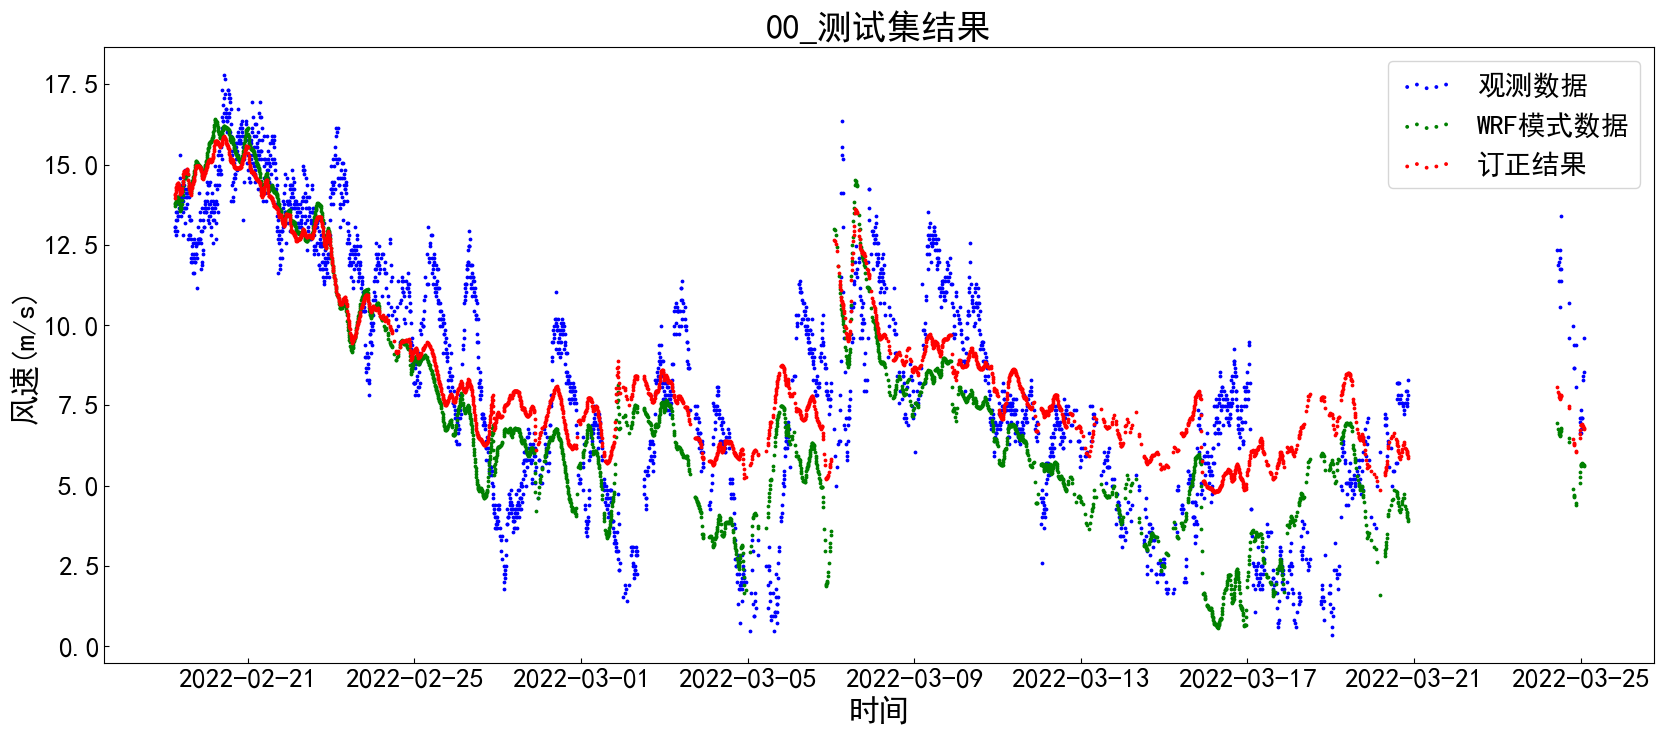

In [36]:
# 设置Matplotlib支持中文显示
plt.rcParams['font.sans-serif'] = ['SimHei']  # 使用黑体
plt.rcParams['axes.unicode_minus'] = False  # 正确显示负号
size = 3
line_width = 1
# 设置画布大小
figsize = (20, 8)
# 创建画布
plt.figure(figsize = figsize)
## 全局设置
# 绘制第一幅图
plt.scatter(datetime, velocity_test_label, color = 'blue', s = size, linewidth = line_width, label = '观测数据')
plt.scatter(datetime, velocity_test_feature, color = 'green', s = size, linewidth = line_width, label = 'WRF模式数据')
plt.scatter(datetime, velocity_test_prediction, color = 'red', s = size, linewidth = line_width, label = '订正结果')

plt.tick_params(direction='in', labelsize=20)
plt.ylabel('风速(m/s)', fontsize=22)
plt.xlabel('时间', fontsize=22)
plt.legend(scatterpoints = 5, loc='upper right',fontsize=20)
plt.title('00_测试集结果',fontsize=25)
plt.savefig('../pic/00_test.png', dpi=300)
plt.show()